In [1]:
using PyPlot

using Distributed
using SharedArrays

addprocs(4)

@everywhere include("../src/num.jl")
@everywhere include("../src/phy.jl")
@everywhere using .num
@everywhere using .physics

@everywhere using DSP
@everywhere using QuadGK

In [79]:
const t = 0.5
U = 3.0
T = 20.
const nωn = 2^12
const nω = 2^12
const Nd = 20
ωrange = [-16.0,16.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.01
const mix = 0.50;
kB = 8.617333262145e-5;

In [80]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

β = 1. / kB / T

ωn = π .* (2 .* collect(1:nωn) .+ 1) ./ β;

In [4]:
@time D0ω = baredos.("cubic",t,ω);

  0.565685 seconds (1.74 M allocations: 123.423 MiB, 7.25% gc time)


In [5]:
@everywhere function ipt_solver(Aw, nf, U)
    Ap = Aw[:,1] .* nf
    Am = Aw[:,2] .* nf
    App = conv_same(Ap,Ap)
    Appp = conv_same(Am, App)
    return -π .* U^2 .* (Appp + Appp[end:-1:1])

    return -π .* U^2 .* (AAB + BBA)
end

@everywhere function ipt_selfcons(ω,dos,t,U,T,itermax,nω,zeroplus,mix,tol)
        gloc = zeros(ComplexF64,nω,2)
        g0 = zeros(ComplexF64,nω,2)
        isi = zeros(Float64,nω,2)
        hsi = zeros(Float64,nω,2)
        A0 = zeros(Float64,nω,2)
        Σ2 = zeros(ComplexF64,nω,2)

        magnet = 0.0

        dω = ω[2] - ω[1]

        nf = fermi.(ω,T)

        η = zeroplus
        α = mix

        ρe = dos[1:4:nω]
        w  = ω[1:4:nω]

        Σ1 = U .* [0.9 -0.9]
    
        for i = 1:nω
            ζ_up = zeta(ω[i] - Σ1[1],η)
            ζ_down = zeta(ω[i] - Σ1[2],η)
        
            intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
            sum = trapz(w,intg)
        
            gloc[i,1] = sum * ζ_down
            gloc[i,2] = sum * ζ_up
        end
        
        for iter = 1:itermax

            gloc_old = deepcopy(gloc)

            ncalc = zeros(Float64,length(gloc[1,:]))
            @fastmath @inbounds for i in 1:2
                ncalc[i] = -1/π .* trapz(ω,imag(gloc[:,i]) .* nf)
            end
        
            Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
            Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
            magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
        
            g0[:,1] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,2])
            g0[:,2] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,1])
            
            for i = 1:2 A0[:,i] = -imag(g0[:,i]) ./ π end
        
            for i = 1:2
                isi[:,i] = ipt_solver(A0,nf,U) * dω * dω
                isi[:,i] = 0.5 .* (isi[:,i] + isi[end:-1:1,i])
                hsi[:,i] = -imag.(Util.hilbert(isi[:,i]))
            end

            Σ2 = hsi .+ im .* isi

            for i = 1:nω
                ζ_up = zeta(ω[i] - Σ1[1] .- Σ2[i,1],η)
                ζ_down = zeta(ω[i] - Σ1[2] .- Σ2[i,2],η)

                intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
                sum = trapz(w,intg)

                gloc[i,1] = sum * ζ_down
                gloc[i,2] = sum * ζ_up
            end

            convg, error = convergent(gloc_old,gloc,ω,nω,tol)

            if convg == false
                gloc = mixing(gloc_old,gloc,mix)
            elseif iter == itermax
                println("Convergent is not achieved. Try Lower Mixings or Higher Iterations")
                break
            elseif convg == true
                #println("Convergent is achieved for U = $U, and T = $T K")
                break
            end
        end

        return gloc,Σ2,magnet

end;

In [88]:
@everywhere function OF_solver(ω,ωn,D0ω,g_loc,Σipt,magnet,Nd,Nωn,Nω,U,T,zeroplus,tol,mix,itermax)

ncalc = [-magnet, magnet]
Σ1 = U .* ncalc
Σ1 = reshape(Σ1,1,2)
    
ρr = D0ω[1:4:nω]
wr  = ω[1:4:nω]
    
Σcalc_r = Σipt

g_iωn = zeros(ComplexF64,nωn,2)
for iω in 1:nωn
    ζ = im .* ωn[iω]
        
    intg =  imag(g_loc[:,1]) ./ (ζ .- ω)
    g_iωn[iω,1] = - trapz(ω,intg) / π
    intg =  imag(g_loc[:,2]) ./ (ζ .- ω)
    g_iωn[iω,2] = - trapz(ω,intg) / π
end
    
Σcalc_iωn = zeros(ComplexF64,nωn,2)
for iω in 1:nωn
    ζ = im .* ωn[iω]
        
    intg =  imag(Σipt[:,1]) ./ (ζ .- ω)
    Σcalc_iωn[iω,1] = - trapz(ω,intg) / π
    intg =  imag(Σipt[:,2]) ./ (ζ .- ω)
    Σcalc_iωn[iω,2] = - trapz(ω,intg) / π
end

nf = fermi.(ω,T)
        
df,wd = zeros(Float64,2,Nd),zeros(Float64,Nd)

Σloc_iωn = zeros(Float64,2)
Glocs = zeros(ComplexF64,nωn,2,Nd,Nd)
Seff = zeros(ComplexF64,Nd,Nd)
P = zeros(Float64,Nd,Nd)
Z = 0.0
Gave = zeros(ComplexF64,nωn,2)
    
magnet = 0.0

Σloc = zeros(Float64,2)
Σcalc_r = zeros(ComplexF64,nω,2)
Glocs_r = zeros(ComplexF64,nω,2,Nd,Nd)
        
dx,wd = QuadGK.gauss(Nd)
wdx = wd * transpose(wd)
for i = 1:2
    df[i,:] = sign(vec([1.0 -1.0])[i] ./ U) .* dx
end

for m_iter in 1:50
            
    giωn_old = deepcopy(g_iωn)
    Σcalciωn_old = deepcopy(Σcalc_iωn)

    Σωn_fluc = Σcalc_iωn
    
    gmf_iωn = 1. ./ ( (1. ./ g_iωn) .+ Σ1 .+ Σωn_fluc)
    
    @fastmath @inbounds for (iNd1,dfn1) in enumerate(df[1,:])
        @fastmath @inbounds for (iNd2,dfn2) in enumerate(df[2,:])

        Σloc_iωn[1] = 0.5 * U .* (ncalc[2].+ dfn2)
        Σloc_iωn[2] = 0.5 * U .* (ncalc[1].+ dfn1)
        Σloc_iωn = reshape(Σloc_iωn,1,2)

        Glocsinv = (1. ./ gmf_iωn) .- Σloc_iωn .- Σωn_fluc

        determ = gmf_iωn .* Glocsinv
        determ = determ[:,1] .* determ[:,2]

        Seff[iNd1,iNd2] = -sum(log.(determ))

        Glocs[:,:,iNd1,iNd2] = 1. ./ Glocsinv

        end
    end
    
    P = exp.(-real.(Seff .- minimum(real.(Seff))))
    Z = sum(P .* wdx)
    
    Gave = zeros(ComplexF64,size(g_iωn))
    @fastmath @inbounds for i = 1:nωn
        @fastmath @inbounds for dim in 1:2 Gave[i,dim] = sum(P[:,:] .* Glocs[i,dim,:,:] .* wdx) end
    end
    Gave = Gave ./ Z
    
    Σcalc_iωn = 1. ./ gmf_iωn .- 1. ./ Gave
    
    Σcalc_iωn = 0. .+ im .* imag(Σcalc_iωn)

    @fastmath @inbounds for (iωn,ωnx) in enumerate(ωn)
        ζup = im*ωn[iωn] - Σ1[1] - Σcalc_iωn[iωn,1]
        ζdw = im*ωn[iωn] - Σ1[2] - Σcalc_iωn[iωn,2]
                
        intg = ρr ./ (ζup*ζdw .- wr.^2.)
        sum = trapz(wr,intg) 
                
        g_iωn[iωn,1] = sum * ζdw
        g_iωn[iωn,2] = sum * ζup
    end
        
    #real iteration ####################################################################
        
    for r_iter = 1:1
    #global Σloc

    gloc_old = deepcopy(g_loc)

    Σ_fluc = Σcalc_r

    gmf = 1. ./ ( (1. ./ g_loc) .+ Σ_fluc .+ Σ1)

    @fastmath @inbounds for (iNd1,dfn1) in enumerate(df[1,:])
        @fastmath @inbounds for (iNd2,dfn2) in enumerate(df[2,:])
            Σloc[1] = 0.5 * U .* (ncalc[2] .+ dfn2)
            Σloc[2] = 0.5 * U .* (ncalc[1] .+ dfn1)
            Σloc = reshape(Σloc,1,2)

            Glocs_r[:,:,iNd1,iNd2] = 1 ./ ( (1. ./ gmf) .- Σloc .- Σ_fluc)
        end
    end

    Gave = zeros(ComplexF64,size(g_loc))
    @fastmath @inbounds for i = 1:nω
        @fastmath @inbounds for dim in 1:2 Gave[i,dim] = sum(P .* Glocs_r[i,dim,:,:] .* wdx) end
    end
    Gave = Gave ./ Z;

    Σcalc_r = 1 ./ gmf .- 1 ./ Gave;
    Σcalc_r = Σcalc_r
        
    hsi = zeros(Float64,size(Σcalc_r))    
    for i in 1:2 hsi[:,i] = imag.(Util.hilbert(imag(Σcalc_r[:,i]))) end
        
    Σcalc_r = hsi .+ im .* imag(Σcalc_r)
        

    @fastmath @inbounds for i = 1:nω
        ζup = ω[i] + im * zeroplus - Σ1[1] - Σcalc_r[i,1]
        ζdw = ω[i] + im * zeroplus - Σ1[2] - Σcalc_r[i,2]
    
        intg = ρr ./ (ζup*ζdw .- wr.^2)
        sum = trapz(wr,intg)
    
        g_loc[i,1] = sum * ζdw
        g_loc[i,2] = sum * ζup
    end

    ncalc = zeros(Float64,2)
    @fastmath @inbounds for i in 1:2
        ncalc[i] = -1/π .* trapz(ω,imag(g_loc[:,i]) .* nf)
    end
    
    Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
    Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
    magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
            
    @fastmath @inbounds for iω in 1:nω
        ζ_up = ω[iω] + im * zeroplus - Σ1[1] - Σcalc_r[iω,1]
        ζ_down = ω[iω] + im * zeroplus - Σ1[2] - Σcalc_r[iω,2]

        intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
        sum = trapz(wr,intg)   

        g_loc[iω,1] = sum * ζ_down
        g_loc[iω,2] = sum * ζ_up
    end

    convg, error = convergent(gloc_old,g_loc,ω,nω,tol)
    
    if convg==true
        break
    end

    end
        
    #real iteration ####################################################################
        
    ncalc[1] = ncalc[1] - sum(ncalc)
    ncalc[2] = ncalc[2] - sum(ncalc)
    
    convg, error = convergent(giωn_old,g_iωn,ωn,nωn,tol)
    
    if convg==true || m_iter==50
        break
    end
    
end
    
    return g_iωn, Σcalc_iωn, P, g_loc, Σcalc_r, magnet

end

In [89]:
@everywhere function ofplusipt(ω,ωn,D0ω,t,U,T,itermax,Nd,nωn,nω,zeroplus,mix,tol)
    glocipt,Σipt,magnet =  ipt_selfcons(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol)
    glociptx = deepcopy(glocipt)
    Σiptx = deepcopy(Σipt)
    magnetx = deepcopy(magnet)
    
    _,_,P,glocr,Σr,magnetofipt = OF_solver(ω,ωn,D0ω,glocipt,Σipt,magnet,Nd,nωn,nω,U,T,zeroplus,tol,mix,itermax)
    println("Done for U = $U eV and T = $T K")
    
    return P,glocr,Σr,magnetofipt,glociptx,Σiptx,magnetx
end

In [90]:
nU = 20
U = range(0.0, length=nU,stop=7.5)
U = convert(Array{Float64},U)

nT = 20
T = range(0.0, length=nT,stop=500)
T = convert(Array{Float64},T)

magnetofipt = SharedArray{Float64}(nU,nT)

@inbounds @sync @distributed for iU in 1:nU
    for iT in 1:nT
       _,_,_,magnetofipt[iU,iT],_,_,_ =  ofplusipt(ω,ωn,D0ω,t,U[iU],T[iT],itermax,Nd,nωn,nω,zeroplus,mix,tol)
    end
end

      From worker 2:	Done for U = 0.0 eV and T = 0.0 K
      From worker 5:	Done for U = 5.921052631578948 eV and T = 0.0 K
      From worker 2:	Done for U = 0.0 eV and T = 26.31578947368421 K
      From worker 4:	Done for U = 3.9473684210526314 eV and T = 0.0 K
      From worker 2:	Done for U = 0.0 eV and T = 52.63157894736842 K
      From worker 3:	Done for U = 1.9736842105263157 eV and T = 0.0 K
      From worker 5:	Done for U = 5.921052631578948 eV and T = 26.31578947368421 K
      From worker 2:	Done for U = 0.0 eV and T = 78.94736842105263 K
      From worker 4:	Done for U = 3.9473684210526314 eV and T = 26.31578947368421 K
      From worker 5:	Done for U = 5.921052631578948 eV and T = 52.63157894736842 K
      From worker 2:	Done for U = 0.0 eV and T = 105.26315789473684 K
      From worker 2:	Done for U = 0.0 eV and T = 131.57894736842104 K
      From worker 3:	Done for U = 1.9736842105263157 eV and T = 26.31578947368421 K
      From worker 5:	Done for U = 5.921052631578948 eV 

      From worker 2:	Done for U = 0.39473684210526316 eV and T = 500.0 K
      From worker 4:	Done for U = 4.342105263157895 eV and T = 78.94736842105263 K
      From worker 5:	Done for U = 6.315789473684211 eV and T = 184.21052631578948 K
      From worker 3:	Done for U = 1.9736842105263157 eV and T = 368.42105263157896 K
      From worker 2:	Done for U = 0.7894736842105263 eV and T = 0.0 K
      From worker 4:	Done for U = 4.342105263157895 eV and T = 105.26315789473684 K
      From worker 5:	Done for U = 6.315789473684211 eV and T = 210.52631578947367 K
      From worker 3:	Done for U = 1.9736842105263157 eV and T = 394.7368421052632 K
      From worker 2:	Done for U = 0.7894736842105263 eV and T = 26.31578947368421 K
      From worker 4:	Done for U = 4.342105263157895 eV and T = 131.57894736842104 K
      From worker 5:	Done for U = 6.315789473684211 eV and T = 236.8421052631579 K
      From worker 3:	Done for U = 1.9736842105263157 eV and T = 421.05263157894734 K
      From worker

      From worker 5:	Done for U = 6.7105263157894735 eV and T = 394.7368421052632 K
      From worker 3:	Done for U = 2.3684210526315788 eV and T = 342.10526315789474 K
      From worker 4:	Done for U = 4.7368421052631575 eV and T = 263.1578947368421 K
      From worker 5:	Done for U = 6.7105263157894735 eV and T = 421.05263157894734 K
      From worker 2:	Done for U = 1.1842105263157894 eV and T = 105.26315789473684 K
      From worker 3:	Done for U = 2.3684210526315788 eV and T = 368.42105263157896 K
      From worker 4:	Done for U = 4.7368421052631575 eV and T = 289.4736842105263 K
      From worker 5:	Done for U = 6.7105263157894735 eV and T = 447.36842105263156 K
      From worker 4:	Done for U = 4.7368421052631575 eV and T = 315.7894736842105 K
      From worker 3:	Done for U = 2.3684210526315788 eV and T = 394.7368421052632 K
      From worker 2:	Done for U = 1.1842105263157894 eV and T = 131.57894736842104 K
      From worker 5:	Done for U = 6.7105263157894735 eV and T = 473.68

      From worker 3:	Done for U = 2.763157894736842 eV and T = 394.7368421052632 K
      From worker 5:	Done for U = 7.5 eV and T = 131.57894736842104 K
      From worker 4:	Done for U = 5.131578947368421 eV and T = 500.0 K
      From worker 3:	Done for U = 2.763157894736842 eV and T = 421.05263157894734 K
      From worker 2:	Done for U = 1.5789473684210527 eV and T = 105.26315789473684 K
      From worker 5:	Done for U = 7.5 eV and T = 157.89473684210526 K
      From worker 4:	Done for U = 5.526315789473684 eV and T = 0.0 K
      From worker 3:	Done for U = 2.763157894736842 eV and T = 447.36842105263156 K
      From worker 5:	Done for U = 7.5 eV and T = 184.21052631578948 K
      From worker 4:	Done for U = 5.526315789473684 eV and T = 26.31578947368421 K
      From worker 3:	Done for U = 2.763157894736842 eV and T = 473.6842105263158 K
      From worker 5:	Done for U = 7.5 eV and T = 210.52631578947367 K
      From worker 2:	Done for U = 1.5789473684210527 eV and T = 131.5789473684

Task (done) @0x00007f1f6c900010

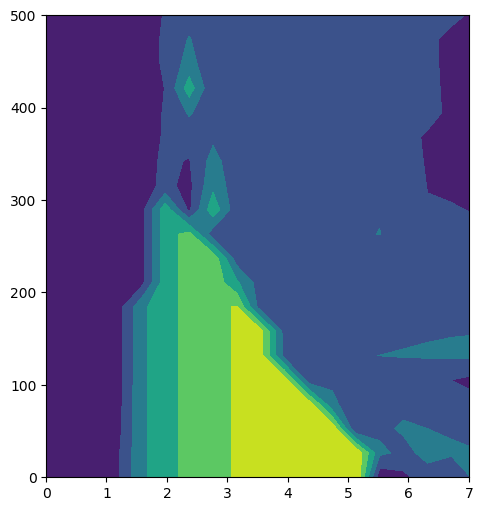

(0, 7)

In [101]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
contourf(U,T,abs.(transpose(magnetofipt)))
plt.ylim(0,500)
plt.xlim(0,7)

In [239]:
using PyPlot

y = [0, 50, 100, 150, 200, 250, 300, 305, 270, 220, 180, 130, 100, 80, 50, 0]
y1 = [0, 50, 100, 180, 250, 290, 320, 355, 340, 320, 270, 180, 140, 90, 60, 0]
x = [1.38, 1.4, 1.42, 1.45, 1.54, 1.69, 1.9, 2.3, 2.6, 3.0, 3.4, 3.9, 4.3, 4.7, 5.0, 5.35]
x1 = [0.9, 1.1, 1.25, 1.3, 1.50, 1.73, 1.9, 2.3, 2.6, 3.0, 3.5, 4.2, 4.6, 4.9, 5.2, 5.7]
y = y .* 8.617333262145e-4
y1 = y1 .* 8.617333262145e-4

q1 = [0.2,0.3,0.33,0.3,0.27]
q2 = [1.7,2.7,3.5,5,6];

In [240]:
using Dierckx
spl = Spline1D(q2,q1)
qx = range(minimum(q2),length=100,maximum(q2))
qx = convert(Array{Float64,1},qx);

splipt = Spline1D(x,y)
iptx = range(minimum(x),length=100,maximum(x))
iptx = convert(Array{Float64,1},iptx);

splof = Spline1D(x1,y1)
ofx = range(minimum(x1),length=100,maximum(x1))
ofx = convert(Array{Float64,1},ofx);

In [241]:
xmesh = range(1,length=2000,stop=10)
xmesh2 = range(0.0,length=2000,stop=7)
heis(x) = 0.25 * 3.83 / x

heis (generic function with 1 method)

In [242]:
intg(tn) = num.trapz(ω,D0ω ./ ω .* tanh.(ω ./ (2 .* tn)))
Umf = 2. ./ intg.(xmesh2) ;

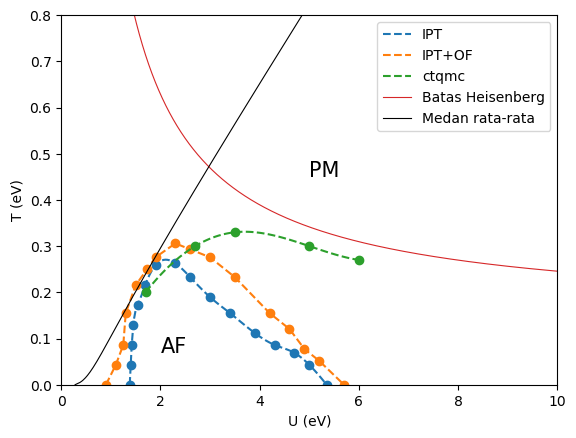

In [246]:
using PyPlot

plt.plot(x,y,"o",color="#1f77b4")
plt.plot(iptx,splipt(iptx),"--",color="#1f77b4",label="IPT")

plt.plot(x1,y1,"o",color="#ff7f0e")
plt.plot(x1,y1,"--",color="#ff7f0e",label="IPT+OF")

plt.plot(q2,q1,"o",color="#2ca02c")
plt.plot(qx,spl(qx),"--",color="#2ca02c",label="ctqmc")

plt.plot(xmesh,heis.(xmesh).+0.15,"-",linewidth=0.8,color="#d62728",label="Batas Heisenberg")

plt.plot(Umf,(1 - 0.282) .* xmesh2 ,"-",linewidth=0.8,color="black",label="Medan rata-rata")

plt.text(2,0.07,"AF",fontsize=15)
plt.text(5,0.45,"PM",fontsize=15)

plt.legend()

plt.ylim(0,0.8)
plt.xlim(0,10)

plt.xlabel("U (eV)")
plt.ylabel("T (eV)")
plt.show
plt.savefig("phasediagram_AF.pdf",format="pdf")